In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.optimize as opt
import datetime as dt
import requests
import json
import os

In [2]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', 500)

# Prepare data

In [3]:
def get_100_candles(ticker: str, tf: str, timestamp_ms_from: int):
    params = {
        'instId': ticker,
        'bar': tf,
        'after': timestamp_ms_from,
    }
    responce = requests.get('https://www.okx.com/api/v5/market/history-mark-price-candles', params)
    if not responce.ok:
        print('Bad request', responce.text)
        return
    candles = []
    for cs in json.loads(responce.text)['data']:
        candle = {
            'dt': dt.datetime.fromtimestamp(int(cs[0]) // 1000),
            'o': float(cs[1]),
            'h': float(cs[2]),
            'l': float(cs[3]),
            'c': float(cs[4]),
        }
        candles.append(candle)
    return candles

In [4]:
def get_timestamp_ms_range(from_date: dt.datetime, till_date: dt.datetime, delta: dt.timedelta):
    ts_range = []
    t = till_date
    while t > from_date:
        timestamp_ms = int(t.timestamp() * 1000)
        ts_range.append(timestamp_ms)
        t -= 100 * delta
    return ts_range

In [5]:
def get_candles_history(ticker: str, tf: str, from_date: dt.datetime, till_date: dt.datetime):
    """
    Get candlestick history of a ticker from OKX 
    """
    tf_to_timedelta = {
        '1D': dt.timedelta(days=1),
        '4H': dt.timedelta(hours=4),
    }
    candles = []
    ts_range = get_timestamp_ms_range(from_date, till_date, tf_to_timedelta[tf])
    for ts_ms in ts_range:
        new_candles = get_100_candles(ticker, tf, ts_ms)
        if new_candles:
            candles.extend(new_candles)
    if len(candles) == 0:
        return 
    df_candles = pd.DataFrame(candles).sort_values('dt')
    return df_candles[df_candles['dt'].between(from_date, till_date)].drop_duplicates('dt').reset_index(drop=True)

In [6]:
DATA_DIR = 'data'
DATA_FILENAME = 'crypto.csv'

path_to_data = os.path.join(DATA_DIR, DATA_FILENAME)
if not os.path.exists(path_to_data):
    tickers = ['BTC-USDT', 'ETH-USDT', 'DOT-USDT', 'OKB-USDT', 'XRP-USDT',
            'SOL-USDT', 'DOGE-TRX', 'TRX-USDT', 'LTC-USDT', 'TON-USDT',
            ]
    tf = '1D'
    date_from = dt.datetime(2020, 1, 1)
    date_till = dt.datetime(2025, 1, 1)
    data = []
    for ticker in tickers:
        print(ticker)
        df = get_candles_history(ticker, tf, date_from, date_till)
        if df is not None:
            ts = pd.Series(data=df['c'].values, index=df['dt'], name=ticker)
            data.append(ts)
    data = pd.concat(data, axis=1)
    data.to_csv(path_to_data)

data = pd.read_csv(path_to_data, index_col='dt', parse_dates=['dt'])
data.dropna(inplace=True)
print(data.shape)

(736, 9)


In [7]:
np.argmin(data.isna().sum(axis=1))

np.int64(0)

# Evaluate strategies

In [8]:
t = list(range(15))
min_hist = 5
PERIOD = 1
size = len(t)

res = []

for i in range(min_hist, size - PERIOD):
    res.append((t[:i], t[i:i + PERIOD]))
print(res)

[([0, 1, 2, 3, 4], [5]), ([0, 1, 2, 3, 4, 5], [6]), ([0, 1, 2, 3, 4, 5, 6], [7]), ([0, 1, 2, 3, 4, 5, 6, 7], [8]), ([0, 1, 2, 3, 4, 5, 6, 7, 8], [9]), ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10]), ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [11]), ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12]), ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [13])]


In [9]:
def timeseries_split(df, period, min_hist):
    size = df.shape[0]
    for i in range(min_hist, size - period):
        yield df.iloc[:i], df.iloc[i: i + period]

In [10]:
def random_portfolio(df_hist):
    n = df_hist.shape[1]
    w = np.random.randn(n, 1)
    w = w / w.sum()
    return w

def uniform_portfolio(df_hist):
    n = df_hist.shape[1]
    w = np.ones((n, 1)) / n
    return w

def single_asset_builder(arg):
    def signle_asset_portfolio(df_hist):
        n = df_hist.shape[1]
        w = np.zeros((n, 1))
        w[arg] = 1
        return w
    return signle_asset_portfolio

def minvar_builder(max_history_leng):
    def minvar_portfolio(df_hist):
        n = df_hist.shape[1]
        df_hist = df_hist.tail(max_history_leng)
        ret = df_hist.diff(PERIOD) / df_hist.shift(PERIOD)
        mu_hat = ret.mean(axis=0).values.reshape((-1, 1))
        cov_hat = ret.cov().values
        cov_hat_inv = np.linalg.inv(cov_hat)
        e = np.ones((n, 1))
        w = cov_hat_inv @ e / (e.T @ cov_hat_inv @ e)
        return w
    return minvar_portfolio

def markowitz_builder(risk_tolerance, max_history_leng):
    def markowitz_portfolio(df_hist):
        if max_history_leng:
            df_hist = df_hist.tail(max_history_leng)
        ret = (df_hist.diff(PERIOD) / df_hist.shift(PERIOD)).dropna()
        mu_hat = ret.mean(axis=0).values.reshape((-1, 1))
        cov_hat = ret.cov().values
        n = df_hist.shape[1]

        def target(x):
            x = x.reshape((-1, 1))
            return x.T @ cov_hat @ x - risk_tolerance * x.T @ mu_hat + x.T @ x
        
        solution = opt.minimize(
            fun=target,
            x0=uniform_portfolio(df_hist).reshape(-1),
            constraints=opt.LinearConstraint(np.ones((1, n)), lb=1, ub=1)
            )
        w = solution.x.reshape((n, 1))
        return w
    return markowitz_portfolio

In [11]:
# число фолдов
736 - 7 - 12*7

645

In [12]:
np.random.randn(27)

PERIOD = 7
min_hist = PERIOD * 12

print(data.shape)
print(f'{data.shape[0] / PERIOD: .1f}')
print(data.index.min(), data.index.max(), sep='\n')

print('число фолдов', data.shape[0] - PERIOD - min_hist)

strategies = {
    # 'random': random_portfolio,
    'uniform': uniform_portfolio,
    'minvar_3w': minvar_builder(PERIOD * 3),
    'minvar_6w': minvar_builder(PERIOD * 6),
    'minvar_12w': minvar_builder(PERIOD * 12),
    'markowitz_0_3w': markowitz_builder(0, PERIOD * 3),
    'markowitz_1_3w': markowitz_builder(1, PERIOD * 3),
    'markowitz_5_3w': markowitz_builder(5, PERIOD * 3),
    'markowitz_10_3w': markowitz_builder(10, PERIOD * 3),
}
for i, c in enumerate(data.columns):
    name = c.lower().split('-')[0]
    strategies[name] = single_asset_builder(i)

summary = {s: [] for s in strategies.keys()}

for run_number, (train, test) in enumerate(timeseries_split(data, PERIOD, min_hist)):
    n = train.shape[1]
    dt = train.iloc[-1].name
    open_price = train.iloc[-1].values.reshape((-1, 1))
    close_price = test.values.T


    for strategy_name, strategy_builder in strategies.items():
        w = strategy_builder(train)

        x = w / open_price
        #assert np.isclose(w.sum(), 1), strategy_name
        if not np.isclose(w.sum(), 1):
            print(f'{strategy_name} not sum to 1')
            continue

        actual_return = (close_price - open_price) / open_price
        pnl = x * actual_return * open_price

        report = pd.DataFrame(index=train.columns)
        # report['open'] = now
        # report['close'] = future[:, -1, np.newaxis]
        # report['diff'] = future[:, -1, np.newaxis] - now
        # report['roi'] = actual_return[:, -1]
        report['w'] = w
        # report['x'] = x
        # report['max_dropdown'] = actual_return.min(axis=1)
        # report['pnl'] = pnl[:, -1, np.newaxis]

        metrics = {
            'dt': dt.strftime('%Y-%m-%d'),
            'total_pnl': float(pnl[:, -1].sum()),
            'total_max_dropdown': float(pnl.sum(axis=0).min()),
        }
        # metrics.update(report.to_dict())
        # metrics['w'] = report['w'].to_dict()
        metrics.update(report['w'].to_dict())
        summary[strategy_name].append(metrics)
        
with open('log.json', 'w') as f:
    f.write(json.dumps(summary, indent=4))

(736, 9)
 105.1
2022-12-27 19:00:00
2024-12-31 19:00:00
число фолдов 645


In [13]:
pnl = pd.concat([pd.DataFrame(v)['total_pnl'].rename(k) for k, v in summary.items()], axis=1)
pnl.tail()

,uniform,minvar_3w,minvar_6w,minvar_12w,markowitz_0_3w,markowitz_1_3w,markowitz_5_3w,markowitz_10_3w,btc,eth,dot,okb,xrp,sol,trx,ltc,ton
640,0.025554,0.062215,0.056221,0.115133,0.024862,0.021462,0.007850,-0.009168,-0.024863,-0.014402,0.001749,0.132301,-0.031297,-0.030230,0.064938,0.051306,0.080488
641,0.024824,0.091244,0.047269,0.139354,0.025026,0.020844,0.004102,-0.016827,-0.031560,-0.006595,-0.024435,0.189876,-0.037772,0.018749,0.043164,-0.009336,0.081324
642,0.035210,0.049676,0.033933,0.078466,0.035174,0.032358,0.021128,0.007080,-0.009079,0.021703,0.013931,0.110027,-0.024780,0.073090,0.067253,0.001392,0.063357
643,0.007550,0.100179,0.039109,0.064803,0.007753,0.006364,0.000807,-0.006163,-0.012196,0.014207,-0.036427,0.101556,-0.055569,0.035434,0.014137,-0.013042,0.019852
644,-0.030564,0.157435,0.026196,0.033673,-0.030368,-0.030331,-0.030198,-0.030027,-0.029430,-0.023101,-0.095452,0.045511,-0.083172,0.003134,-0.007005,-0.056069,-0.029493


In [14]:
pnl.describe()

,uniform,minvar_3w,minvar_6w,minvar_12w,markowitz_0_3w,markowitz_1_3w,markowitz_5_3w,markowitz_10_3w,btc,eth,dot,okb,xrp,sol,trx,ltc,ton
count,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000,645.000000
mean,0.014857,0.016973,0.006003,0.013499,0.014783,0.016842,0.025075,0.035368,0.015507,0.009990,0.007054,0.004319,0.025876,0.031755,0.017624,0.005589,0.015999
std,0.070434,0.123240,0.080005,0.069608,0.070162,0.074780,0.106822,0.160486,0.066427,0.078637,0.110244,0.076013,0.148157,0.128964,0.077493,0.091233,0.111794
min,-0.214001,-0.261414,-0.202731,-0.164017,-0.213860,-0.216754,-0.249555,-0.410588,-0.202398,-0.269381,-0.277164,-0.175032,-0.233354,-0.309284,-0.187850,-0.239245,-0.212294
25%,-0.030564,-0.040518,-0.041756,-0.026743,-0.030464,-0.030928,-0.033921,-0.040087,-0.023952,-0.038240,-0.060063,-0.033765,-0.047733,-0.056099,-0.016024,-0.044276,-0.053405
50%,0.011885,0.003840,0.001892,0.005099,0.012270,0.012318,0.011864,0.009148,0.007232,0.002251,-0.004884,-0.003302,0.000996,0.018981,0.015756,0.000141,-0.000233
75%,0.053529,0.050494,0.045763,0.037082,0.053108,0.053119,0.060842,0.066337,0.048337,0.051394,0.057544,0.031816,0.046351,0.098419,0.038749,0.049040,0.059464
max,0.283979,1.458296,0.343653,0.420782,0.281199,0.376986,0.916087,1.614265,0.257600,0.336192,0.618821,0.338632,1.023532,0.740882,0.740697,0.529393,0.696395


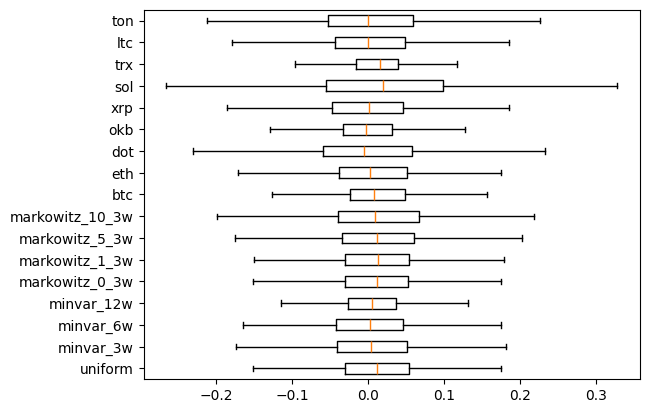

In [15]:
plt.boxplot(pnl, showfliers=False, orientation='horizontal', tick_labels=pnl.columns)
plt.show()

In [16]:
pnl.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
markowitz_10_3w,645.0,0.035368,0.160486,-0.410588,-0.040087,0.009148,0.066337,1.614265
sol,645.0,0.031755,0.128964,-0.309284,-0.056099,0.018981,0.098419,0.740882
xrp,645.0,0.025876,0.148157,-0.233354,-0.047733,0.000996,0.046351,1.023532
markowitz_5_3w,645.0,0.025075,0.106822,-0.249555,-0.033921,0.011864,0.060842,0.916087
trx,645.0,0.017624,0.077493,-0.187850,-0.016024,0.015756,0.038749,0.740697
minvar_3w,645.0,0.016973,0.123240,-0.261414,-0.040518,0.003840,0.050494,1.458296
markowitz_1_3w,645.0,0.016842,0.074780,-0.216754,-0.030928,0.012318,0.053119,0.376986
ton,645.0,0.015999,0.111794,-0.212294,-0.053405,-0.000233,0.059464,0.696395
btc,645.0,0.015507,0.066427,-0.202398,-0.023952,0.007232,0.048337,0.257600
uniform,645.0,0.014857,0.070434,-0.214001,-0.030564,0.011885,0.053529,0.283979


In [17]:
df = pnl.describe().T.reset_index(names='name')
px.scatter(df, x='std', y='mean', text='name')